In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

Turning quantum nodes into Torch Layers
=======================================

::: {.meta}
:property=\"og:description\": Learn how to create hybrid ML models in
PennyLane using Torch :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets//PyTorch_icon.png>
:::

::: {.related}
tutorial\_qnn\_module\_tf Turning quantum nodes into Keras Layers
:::

*Author: Tom Bromley --- Posted: 02 November 2020. Last updated: 28
January 2021.*

Creating neural networks in [PyTorch](https://pytorch.org/) is easy
using the [nn module](https://pytorch.org/docs/stable/nn.html). Models
are constructed from elementary *layers* and can be trained using the
PyTorch API. For example, the following code defines a two-layer network
that could be used for binary classification:


In [2]:
import torch

layer_1 = torch.nn.Linear(2, 2)
layer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)

layers = [layer_1, layer_2, softmax]
model = torch.nn.Sequential(*layers)

**What if we want to add a quantum layer to our model?** This is
possible in PennyLane:
`QNodes <../glossary/hybrid_computation>`{.interpreted-text role="doc"}
can be converted into `torch.nn` layers and combined with the wide range
of built-in classical [layers](https://pytorch.org/docs/stable/nn.html)
to create truly hybrid models. This tutorial will guide you through a
simple example to show you how it\'s done!

::: {.note}
::: {.title}
Note
:::

A similar demo explaining how to
`turn quantum nodes into Keras layers <tutorial_qnn_module_tf>`{.interpreted-text
role="doc"} is also available.
:::

Fixing the dataset and problem
==============================

Let us begin by choosing a simple dataset and problem to allow us to
focus on how the hybrid model is constructed. Our objective is to
classify points generated from scikit-learn\'s binary-class
[make\_moons()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)
dataset:


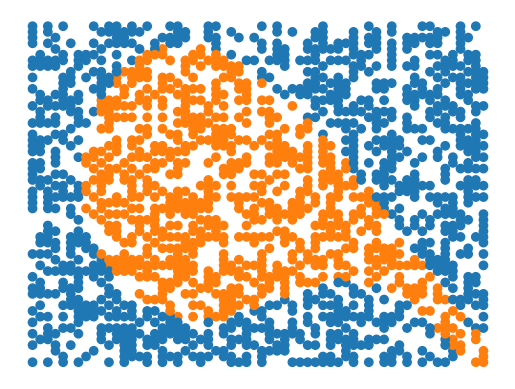

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

X = np.loadtxt("trainX.txt")
y = np.loadtxt("trainY.txt")
# X = X[:300]
# y = y[:300]

y_ = torch.unsqueeze(torch.tensor(y, dtype=torch.int64), 1) # used for one-hot encoded labels
y_hot = torch.scatter(torch.zeros((len(y), 2)), 1, y_, 1)

c = ["#1f77b4" if y_ == 0 else "#ff7f0e" for y_ in y]  # colours for each class
plt.axis("off")
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

Defining a QNode
================

Our next step is to define the QNode that we want to interface with
`torch.nn`. Any combination of device, operations and measurements that
is valid in PennyLane can be used to compose the QNode. However, the
QNode arguments must satisfy additional `conditions
<code/api/pennylane.qnn.TorchLayer>`{.interpreted-text role="doc"}
including having an argument called `inputs`. All other arguments must
be arrays or tensors and are treated as trainable weights in the model.
We fix a two-qubit QNode using the
`default.qubit <code/api/pennylane.devices.default_qubit.DefaultQubit>`{.interpreted-text
role="doc"} simulator and operations from the
`templates <introduction/templates>`{.interpreted-text role="doc"}
module.


In [31]:
import pennylane as qml

n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

Interfacing with Torch
======================

With the QNode defined, we are ready to interface with `torch.nn`. This
is achieved using the `~pennylane.qnn.TorchLayer`{.interpreted-text
role="class"} class of the `~pennylane.qnn`{.interpreted-text
role="mod"} module, which converts the QNode to the elementary building
block of `torch.nn`: a *layer*. We shall see in the following how the
resultant layer can be combined with other well-known neural network
layers to form a hybrid model.

We must first define the `weight_shapes` dictionary. Recall that all of
the arguments of the QNode (except the one named `inputs`) are treated
as trainable weights. For the QNode to be successfully converted to a
layer in `torch.nn`, we need to provide the details of the shape of each
trainable weight for them to be initialized. The `weight_shapes`
dictionary maps from the argument names of the QNode to corresponding
shapes:


In [32]:
n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

In our example, the `weights` argument of the QNode is trainable and has
shape given by `(n_layers, n_qubits)`, which is passed to
`~pennylane.templates.layers.BasicEntanglerLayers`{.interpreted-text
role="func"}.

Now that `weight_shapes` is defined, it is easy to then convert the
QNode:


In [33]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

With this done, the QNode can now be treated just like any other
`torch.nn` layer and we can proceed using the familiar Torch workflow.

Creating a hybrid model
=======================

Let\'s create a basic three-layered hybrid model consisting of:

1.  a 2-neuron fully connected classical layer
2.  our 2-qubit QNode converted into a layer
3.  another 2-neuron fully connected classical layer
4.  a softmax activation to convert to a probability vector

A diagram of the model can be seen in the figure below.

![](/_static/demonstration_assets/qnn_module/qnn_torch.png){.align-center
width="100.0%"}

We can construct the model using the
[Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)
API:


In [34]:
clayer_1 = torch.nn.Linear(2, 2)
clayer_2 = torch.nn.Linear(2, 2)
softmax = torch.nn.Softmax(dim=1)
layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

Training the model
==================

We can now train our hybrid model on the classification dataset using
the usual Torch approach. We\'ll use the standard
[SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)
optimizer and the mean absolute error loss function:


In [45]:
opt = torch.optim.Adam(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss()

Note that there are more advanced combinations of optimizer and loss
function, but here we are focusing on the basics.

The model is now ready to be trained!


In [46]:
X = torch.tensor(X, requires_grad=True).float()
y_hot = y_hot.float()

batch_size = 200
batches = len(y) // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=5, shuffle=True, drop_last=True
)

epochs = 20

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    if epoch % 2 == 0:
        print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

/var/folders/fd/2w8lmrtj2kqffk3mlkysjzqm0000gn/T/ipykernel_39629/2952556892.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, requires_grad=True).float()


Average loss over epoch 1: 16.8750
Average loss over epoch 3: 16.8750
Average loss over epoch 5: 16.8750
Average loss over epoch 7: 16.8750
Average loss over epoch 9: 16.8750
Average loss over epoch 11: 16.8750
Average loss over epoch 13: 16.8750
Average loss over epoch 15: 16.8750
Average loss over epoch 17: 16.8750
Average loss over epoch 19: 16.8750
Accuracy: 57.8125%


How did we do? The model looks to have successfully trained and the
accuracy is reasonably high. In practice, we would aim to push the
accuracy higher by thinking carefully about the model design and the
choice of hyperparameters such as the learning rate.

Creating non-sequential models
==============================

The model we created above was composed of a sequence of classical and
quantum layers. This type of model is very common and is suitable in a
lot of situations. However, in some cases we may want a greater degree
of control over how the model is constructed, for example when we have
multiple inputs and outputs or when we want to distribute the output of
one layer into multiple subsequent layers.

Suppose we want to make a hybrid model consisting of:

1.  a 4-neuron fully connected classical layer
2.  a 2-qubit quantum layer connected to the first two neurons of the
    previous classical layer
3.  a 2-qubit quantum layer connected to the second two neurons of the
    previous classical layer
4.  a 2-neuron fully connected classical layer which takes a
    4-dimensional input from the combination of the previous quantum
    layers
5.  a softmax activation to convert to a probability vector

This model can also be constructed by creating a new class that inherits
from the `torch.nn`
[Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) and
overriding the `forward()` method:


In [47]:
class HybridModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.clayer_1 = torch.nn.Linear(2, 4)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.qlayer_2 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.clayer_2 = torch.nn.Linear(4, 2)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.clayer_1(x)
        x_1, x_2 = torch.split(x, 2, dim=1)
        x_1 = self.qlayer_1(x_1)
        x_2 = self.qlayer_2(x_2)
        x = torch.cat([x_1, x_2], axis=1)
        x = self.clayer_2(x)
        return self.softmax(x)

model = HybridModel()

As a final step, let\'s train the model to check if it\'s working:


In [49]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 30

for epoch in range(epochs):

    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        loss_evaluated = loss(model(xs), ys)
        loss_evaluated.backward()

        opt.step()

        running_loss += loss_evaluated

    avg_loss = running_loss / batches
    if epoch % 2 == 0:
        print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
predictions = torch.argmax(y_pred, axis=1).detach().numpy()

correct = [1 if p == p_true else 0 for p, p_true in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
print(f"Accuracy: {accuracy * 100}%")

Average loss over epoch 1: 16.8789
Average loss over epoch 3: 16.8788
Average loss over epoch 5: 16.8788
Average loss over epoch 7: 16.8788
Average loss over epoch 9: 16.8788
Average loss over epoch 11: 16.8787
Average loss over epoch 13: 16.8787
Average loss over epoch 15: 16.8787
Average loss over epoch 17: 16.8787
Average loss over epoch 19: 16.8787
Average loss over epoch 21: 16.8786
Average loss over epoch 23: 16.8786
Average loss over epoch 25: 16.8786
Average loss over epoch 27: 16.8786
Average loss over epoch 29: 16.8786
Accuracy: 57.8125%
